# Random NN models

This tutorial shows how to build neural network models.
We will learn how to calculate compositional descriptors using `xenonpy.descriptor.Compositions` calculator and train our model using `xenonpy.model.training` modules.

In this tutorial, we will use some inorganic sample data from materials project. 
If you don't have it, please see https://github.com/yoshida-lab/XenonPy/blob/master/samples/build_sample_data.ipynb.

#### useful functions

Running the following cell will load some commonly used packages, such as `numpy`, `pandas`, and so on. It will also import some in-house functions used in this tutorial. See `samples/tools.ipynb` to check what will be imported.

In [1]:
%run tools.ipynb

## Sequential linear model

We will use `xenonpy.model.SequentialLinear` to build a sequential linear model. The basic layer in `SequentialLinear` model is `xenonpy.model.LinearLayer`

In [2]:
from xenonpy.model import SequentialLinear, LinearLayer
SequentialLinear?

Init signature:
SequentialLinear(
    in_features: int,
    out_features: int,
    bias: bool = True,
    *,
    h_neurons: Union[Tuple[float, ...], Tuple[int, ...]] = (),
    h_bias: Union[bool, Tuple[bool, ...]] = True,
    h_dropouts: Union[float, Tuple[float, ...]] = 0.1,
    h_normalizers: Union[float, NoneType, Tuple[Union[float, NoneType], ...]] = 0.1,
    h_activation_funcs: Union[Callable, NoneType, Tuple[Union[Callable, NoneType], ...]] = ReLU(),
)
Docstring:     
Sequential model with linear layers and configurable other hype-parameters.
e.g. ``dropout``, ``hidden layers``
Init docstring:
Parameters
----------
in_features
    Size of input.
out_features
    Size of output.
bias
    Enable ``bias`` in input layer.
h_neurons
    Number of neurons in hidden layers.
    Can be a tuple of floats. In that case,
    all these numbers will be used to calculate the neuron numbers.
    e.g. (0.5, 0.4, ...) will be expanded as (in_features * 0.5, in_features * 0.4, ...)
h_bias
    ``bi

In [3]:
LinearLayer?

Init signature:
LinearLayer(
    in_features: int,
    out_features: int,
    bias: bool = True,
    *,
    dropout: float = 0.0,
    activation_func: Callable = ReLU(),
    normalizer: Union[float, NoneType] = 0.1,
)
Docstring:     
Base NN layer. This is a wrap around PyTorch.
See here for details: http://pytorch.org/docs/master/nn.html#
Init docstring:
Parameters
----------
in_features:
    Size of each input sample.
out_features:
    Size of each output sample
dropout: float
    Probability of an element to be zeroed. Default: 0.5
activation_func: func
    Activation function.
normalizer: func
    Normalization layers
File:           ~/projects/XenonPy/xenonpy/model/sequential.py
Type:           type
Subclasses:     


Following the official suggestion from PyTorch, `SequentialLinear` is a python class that inherit the `torch.nn.Module` class. Users can specify the hyperparameters to get a fully customized model object. For example:

In [4]:
model = SequentialLinear(290, 1, h_neurons=(0.8, 0.7, 0.6))
model

SequentialLinear(
  (layer_0): LinearLayer(
    (linear): Linear(in_features=290, out_features=232, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(232, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_1): LinearLayer(
    (linear): Linear(in_features=232, out_features=203, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(203, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_2): LinearLayer(
    (linear): Linear(in_features=203, out_features=174, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(174, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (output): Linear(in_features=174, out_features=1, bias=True)
)

#### fully randomized model generation

Process of random model generation:

1. using a random parameter generator to generate a set of parameter.
2. using the generated parameter set to setup a model object.
3. loop step 1 and 2 as many times as needed.

We provided a general parameter generator `xenonpy.utils.ParameterGenerator`  to do all the 3 steps for any callable object.

In [5]:
from xenonpy.utils import ParameterGenerator
ParameterGenerator?

Init signature:
ParameterGenerator(
    seed: Union[int, NoneType] = None,
    **kwargs: Union[Any, Sequence, Callable, Dict],
)
Docstring:      Generator for parameter set generating.
Init docstring:
Parameters
----------
seed
    Numpy random seed.
kwargs
    Parameter candidate.
File:           ~/projects/XenonPy/xenonpy/utils/parameter_gen.py
Type:           type
Subclasses:     


Calling an instance of `ParameterGenerator` will return a generator.
This generator can randomly select parameters from parameter candidates and yield them as a dict. This is what we want in step 1.

In [6]:
from math import ceil
from random import uniform

generator = ParameterGenerator(
    in_features=290,
    out_features=1,
    h_neurons=dict(
        data=[ceil(uniform(0.1, 1.2) * 290) for _ in range(100)], 
        repeat=(2, 3)
    )
)

Because `generator` is a generator, `for ... in ...` statement can be applied. 
For example, we can use `for parameters in generator(num_of_models)` to loop all these generated parameter sets.

In [7]:
for parameters in generator(num=10):
    print(parameters)

{'in_features': 290, 'out_features': 1, 'h_neurons': (70, 109)}
{'in_features': 290, 'out_features': 1, 'h_neurons': (135, 45)}
{'in_features': 290, 'out_features': 1, 'h_neurons': (216, 261, 79)}
{'in_features': 290, 'out_features': 1, 'h_neurons': (111, 88, 49)}
{'in_features': 290, 'out_features': 1, 'h_neurons': (216, 79, 47)}
{'in_features': 290, 'out_features': 1, 'h_neurons': (161, 45)}
{'in_features': 290, 'out_features': 1, 'h_neurons': (193, 161, 78)}
{'in_features': 290, 'out_features': 1, 'h_neurons': (90, 36, 234)}
{'in_features': 290, 'out_features': 1, 'h_neurons': (230, 83, 295)}
{'in_features': 290, 'out_features': 1, 'h_neurons': (171, 247)}


For step 2, we can give a model class to the `factory` parameter as a factory function.
If `factory` parameter is given, generator will feed generated parameters to the factory function automatically and yield the result as a second return in each loop. For example:

In [8]:
for parameters, model in generator(2, factory=SequentialLinear):
    print('parameters: ', parameters)
    print(model, '\n')

parameters:  {'in_features': 290, 'out_features': 1, 'h_neurons': (182, 335, 204)}
SequentialLinear(
  (layer_0): LinearLayer(
    (linear): Linear(in_features=290, out_features=182, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(182, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_1): LinearLayer(
    (linear): Linear(in_features=182, out_features=335, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(335, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_2): LinearLayer(
    (linear): Linear(in_features=335, out_features=204, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(204, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (output): Linear(in_features=204, out_features=1, bias=True)
) 

parameters:  {'in_features': 290, 'out_features': 1, 'h_neurons': (108, 255)}
Sequent

### scheduled random model

We also enable users to generate parameters in a functional way by given a function as candidate parameters. In this case, the function accept an int number as vector length and a vector of generated parameters. For example, generate a `n` length vector with float numbers sorted in ascending.

In [9]:
generator = ParameterGenerator(
    in_features=290,
    out_features=1,
    h_neurons=dict(
        data=lambda n: sorted(np.random.uniform(0.2, 0.8, size=n), reverse=True), 
        repeat=(2, 3)
    )
)

In [10]:
for parameters, model in generator(2, factory=SequentialLinear):
    print('parameters: ', parameters)
    print(model, '\n')

parameters:  {'in_features': 290, 'out_features': 1, 'h_neurons': (0.7954011465554711, 0.6993610045591458)}
SequentialLinear(
  (layer_0): LinearLayer(
    (linear): Linear(in_features=290, out_features=231, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(231, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_1): LinearLayer(
    (linear): Linear(in_features=231, out_features=203, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(203, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (output): Linear(in_features=203, out_features=1, bias=True)
) 

parameters:  {'in_features': 290, 'out_features': 1, 'h_neurons': (0.798810246990777, 0.38584535382368323, 0.29569841893337045)}
SequentialLinear(
  (layer_0): LinearLayer(
    (linear): Linear(in_features=290, out_features=232, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(232, eps=

## Model training

We provide a general and extendable model training system for neural network models.
By customizing the extensions, users can fully control their model training process, and save the training results following the *XenonPy.MDL* format automatically.

All these modules and extensions are under the `xenonpy.model.training`.

In [11]:
import torch
import matplotlib.pyplot as plt
from pymatgen import Structure

from xenonpy.model.training import Trainer, SGD, MSELoss, Adam, ReduceLROnPlateau, ExponentialLR, ClipValue

from xenonpy.datatools import preset, Splitter
from xenonpy.descriptor import Compositions

### prepare training/testing data

If you followed the tutorial in https://github.com/yoshida-lab/XenonPy/blob/master/samples/build_sample_data.ipynb,
the sample data should be save at `~/.xenonpy/userdata` with name `mp_samples.pd.xz`.
You can use `pd.read_pickle` to load this file but we suggest that you use our `xenonpy.datatools.preset` module.

We chose `volume` as the example to demonstrate how to use our training system. We only use the data which `volume` are smaller than 2,500 to avoid the disparate data.
we select data in `pandas.DataFrame` and calculate the descriptors using `xenonpy.descriptor.Compositions` calculator.
It is noticed that the input for a neuron network model in pytorch must has shape (N x M x ...), which mean if the input is a 1-D vector, it should be reshaped to 2-D, e.g. (N) -> (N x 1).

In [12]:
# if you have not have the samples data
# preset.build('mp_samples', api_key=<your materials project api key>)

from xenonpy.datatools import preset

data = preset.mp_samples
data.head(3)

,band_gap,composition,density,e_above_hull,efermi,elements,final_energy_per_atom,formation_energy_per_atom,pretty_formula,structure,volume
mp-1008807,0.0000,"{'Rb': 1.0, 'Cu': 1.0, 'O': 1.0}",4.784634,0.996372,1.100617,"[Rb, Cu, O]",-3.302762,-0.186408,RbCuO,"[[-3.05935361 -3.05935361 -3.05935361] Rb, [0....",57.268924
mp-1009640,0.0000,"{'Pr': 1.0, 'N': 1.0}",8.145777,0.759393,5.213442,"[Pr, N]",-7.082624,-0.714336,PrN,"[[0. 0. 0.] Pr, [1.57925232 1.57925232 1.58276...",31.579717
mp-1016825,0.7745,"{'Hf': 1.0, 'Mg': 1.0, 'O': 3.0}",6.165888,0.589550,2.424570,"[Hf, Mg, O]",-7.911723,-3.060060,HfMgO3,"[[2.03622802 2.03622802 2.03622802] Hf, [0. 0....",67.541269


In case of the system did not automatically download some descriptor data in XenonPy, please run the following code to sync the data.

In [13]:
from xenonpy.datatools import preset
preset.sync('elements')
preset.sync('elements_completed')

fetching dataset `elements` from https://github.com/yoshida-lab/dataset/releases/download/v0.1.3/elements.pd.xz.
fetching dataset `elements_completed` from https://github.com/yoshida-lab/dataset/releases/download/v0.1.3/elements_completed.pd.xz.


In [14]:
prop = data[data.volume <= 2500]['volume'].to_frame()  # reshape to 2-D
desc = Compositions(featurizers='classic').transform(data.loc[prop.index]['composition'])

desc.head(3)
prop.head(3)

,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
mp-1008807,24.666667,174.067140,209.333333,25.666667,55.004267,1297.063333,72.868680,1646.90,139.333333,128.333333,...,1.0,2.0,0.360,0.02658,152.0,150.0,182.0,349.5,317.5,0.802
mp-1009640,33.000000,137.000000,232.500000,19.050000,77.457330,1931.200000,43.182441,1892.85,137.000000,123.500000,...,2.0,2.0,0.192,0.02583,155.0,166.0,193.0,360.6,333.6,1.100
mp-1016825,21.600000,153.120852,203.400000,13.920000,50.158400,1420.714000,76.663625,343.82,102.800000,96.000000,...,2.0,2.0,0.146,0.02658,152.0,150.0,182.0,302.1,317.5,0.802


,volume
mp-1008807,57.268924
mp-1009640,31.579717
mp-1016825,67.541269


In [15]:
from xenonpy.datatools import preset

Use the `xenonpy.datatools.Splitter` to split data into training and test sets.

In [16]:
Splitter?

Init signature:
Splitter(
    size: int,
    *,
    test_size: Union[float, int] = 0.2,
    k_fold: Union[int, Iterable, NoneType] = None,
    random_state: Union[int, NoneType] = None,
    shuffle: bool = True,
)
Docstring:      Data splitter for train and test
Init docstring:
Parameters
----------
size
    Total sample size.
    All data must have same length of their first dim,
test_size
    If float, should be between ``0.0`` and ``1.0`` and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. Can be ``0`` if cv is ``None``.
    In this case, :meth:`~Splitter.cv` will yield a tuple only contains ``training`` and ``validation``
    on each step. By default, the value is set to 0.2.
k_fold
    Number of k-folds.
    If ``int``, Must be at least 2.
    If ``Iterable``, it should provide label for each element which will be used for group cv.
    In this case, the input of :meth:`~Splitter.cv` must be a :c

In [17]:
sp = Splitter(prop.shape[0])
x_train, x_val, y_train, y_val = sp.split(desc, prop)

x_train.shape
y_train.shape
x_val.shape
y_val.shape

(738, 290)

(738, 1)

(185, 290)

(185, 1)

### model training

Model training in pytorch is very flexible.
The [official document](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) explains the concept with examples.
In short, training a neuron network model includes:
1. calculating loss of training data for the model.
2. executing the backpropagation to update the weights between each neuron.
3. looping over step 1 and 2 until convergence.

In step 1, a calculator, often called `loss function`, is needed to calculate the loss.
In step 2, an optimizer will be used.
`xenonpy.model.training.Trainer` covers step 3.

Here is how you will do it in XenonPy:

In [18]:
model = SequentialLinear(290, 1, h_neurons=(0.8, 0.6, 0.4, 0.2))
model

SequentialLinear(
  (layer_0): LinearLayer(
    (linear): Linear(in_features=290, out_features=232, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(232, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_1): LinearLayer(
    (linear): Linear(in_features=232, out_features=174, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(174, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_2): LinearLayer(
    (linear): Linear(in_features=174, out_features=116, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(116, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_3): LinearLayer(
    (linear): Linear(in_features=116, out_features=58, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(58, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation):

In [19]:
trainer = Trainer(
    model=model,
    optimizer=Adam(lr=0.01),
    loss_func=MSELoss()
)
trainer

Trainer(clip_grad=None, cuda=None, epochs=200, loss_func=MSELoss(),
        lr_scheduler=None,
        model=SequentialLinear(
  (layer_0): LinearLayer(
    (linear): Linear(in_features=290, out_features=232, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(232, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_1): LinearLayer(
    (linear): Li...
    (linear): Linear(in_features=116, out_features=58, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(58, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (output): Linear(in_features=58, out_features=1, bias=True)
),
        non_blocking=False,
        optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
))

In [20]:
trainer.fit(
    x_train=torch.tensor(x_train.values, dtype=torch.float),
    y_train=torch.tensor(y_train.values, dtype=torch.float),
    epochs=400
)

Training: 100%|██████████| 400/400 [00:06<00:00, 60.86it/s]


,total_iters,i_epoch,i_batch,train_mse_loss
397,397,398,1,3684.717041
398,398,399,1,3058.761719
399,399,400,1,3039.683350


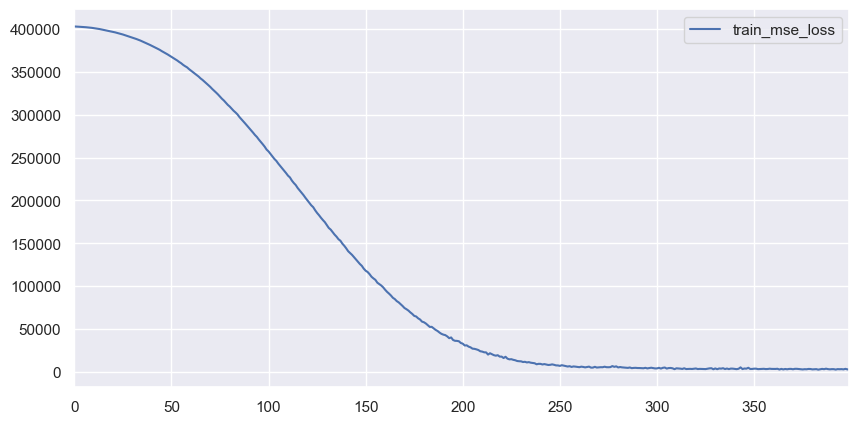

In [21]:
_, ax = plt.subplots(figsize=(10, 5), dpi=100)
trainer.training_info.tail(3)
trainer.training_info.plot(y=['train_mse_loss'], ax=ax)

Missing directory and/or file name information!


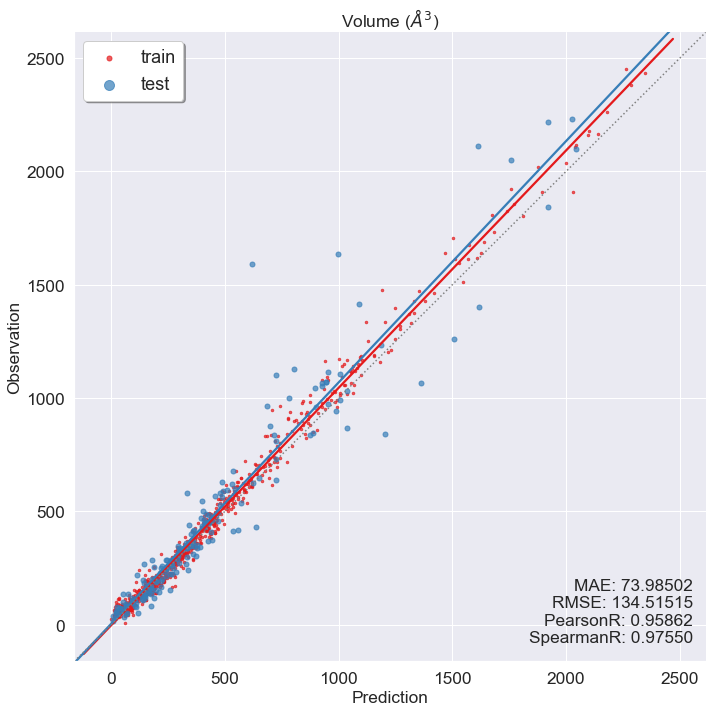

In [22]:
y_pred = trainer.predict(x_in=torch.tensor(x_val.values, dtype=torch.float)).detach().numpy().flatten()
y_true = y_val.values.flatten()

y_fit_pred = trainer.predict(x_in=torch.tensor(x_train.values, dtype=torch.float)).detach().numpy().flatten()
y_fit_true = y_train.values.flatten()

draw(y_true, y_pred, y_fit_true, y_fit_pred, prop_name='Volume ($\AA^3$)')

You can see that although `trainer` can keep training info automatically for us, we still need to convert `DataFrame` to `torch.Tensor` and convert dtype from `np.double` to `torch.float` during training, and eventually convert them back during prediction ourselves. Also, overfitting could be observed in the **prediction vs observation** plot. One possible caused is using all training data in each epoch of the training process. We can use a technique called mini-batch to avoid overfitting, but that will require more coding.

To skip these tedious coding steps, we provide an extension system.

First, we use `ArrayDataset` to wrap our data, and use `torch.utils.data.DataLoader` to a build mini-batch loader.

In [23]:
from xenonpy.model.training.dataset import ArrayDataset
from torch.utils.data import DataLoader

In [24]:
train_dataset = DataLoader(ArrayDataset(x_train, y_train), shuffle=True, batch_size=100)
val_dataset = DataLoader(ArrayDataset(x_val, y_val), batch_size=1000)

Second, we use `TensorConverter` extension to automatically convert data between `numpy` and `torch.Tensor`.
Additionally, we want to trace some stopping criterion and use early stopping when these criterion stop improving.
This can be done by using `Validator`.

At last, to save our model for latter use, just add `Persist` to the trainer and saving will be done in silent.

In [25]:
from xenonpy.model.training.extension import Validator, TensorConverter, Persist
from xenonpy.model.training.dataset import ArrayDataset
from xenonpy.model.utils import regression_metrics

We use `trainer.extend` method to stack up extensions. Note that extensions will be executed in the order of insertion, so `TensorConverter` should always go first and `Persist` be the last.

In [26]:
trainer = Trainer(
    optimizer=Adam(lr=0.01),
    loss_func=MSELoss(),
).extend(
    TensorConverter(),
    Validator(metrics_func=regression_metrics, early_stopping=30, trace_order=5, mae=0.0, pearsonr=1.0),
)

In [27]:
Persist?

Init signature:
Persist(
    path: Union[pathlib.Path, str] = '.',
    *,
    model_class: Callable = None,
    model_params: Union[tuple, dict, <built-in function any>] = None,
    increment=False,
    sync_training_step=False,
    **describe: Any,
)
Docstring:      Trainer extension for data persistence
Init docstring:
Parameters
----------
path
    Path for model saving.
model_class
    A factory function for model reconstructing.
    In most case this is the model class inherits from :class:`torch.nn.Module`
model_params
    The parameters for model reconstructing.
    This can be anything but in general this is a dict which can be used as kwargs parameters.
increment
    If ``True``, dir name of path will be decorated with a auto increment number,
    e.g. use ``model_dir@1`` for ``model_dir``.
sync_training_step
    If ``True``, will save ``trainer.training_info`` at each iteration.
    Default is ``False``, only save ``trainer.training_info`` at each epoch.
describe:
    Any oth

`Persist` need a path to save model. For convenience, we prepare the path name by concatenating the number of neurons in a model.

In [28]:
def make_name(model):
    name = []
    for n, m in model.named_children():
        if 'layer_' in n:
            name.append(str(m.linear.in_features))
        else:
            name.append(str(m.in_features))
            name.append(str(m.out_features))
    return '-'.join(name)

In [29]:
model = SequentialLinear(290, 1, h_neurons=(0.8, 0.6, 0.4, 0.2))
model

model_name = make_name(model)
persist = Persist(
    f'trained_models/{model_name}', 
    # -^- required -^-

    # -v- optional -v-
    increment=False, 
    sync_training_step=True,
    author='Chang Liu',
    email='liu.chang.1865@gmail.com',
    dataset='materials project',
)
_ = trainer.extend(persist)
trainer.reset(to=model)

trainer.fit(training_dataset=train_dataset, validation_dataset=val_dataset, epochs=400)
persist(splitter=sp, data_indices=prop.index.tolist())  # <-- calling of this method only after the model training

SequentialLinear(
  (layer_0): LinearLayer(
    (linear): Linear(in_features=290, out_features=232, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(232, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_1): LinearLayer(
    (linear): Linear(in_features=232, out_features=174, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(174, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_2): LinearLayer(
    (linear): Linear(in_features=174, out_features=116, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(116, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_3): LinearLayer(
    (linear): Linear(in_features=116, out_features=58, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(58, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation):

Training:  12%|█▏        | 47/400 [00:15<02:06,  2.78it/s]

Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 31 iterations, finish training at iteration 372


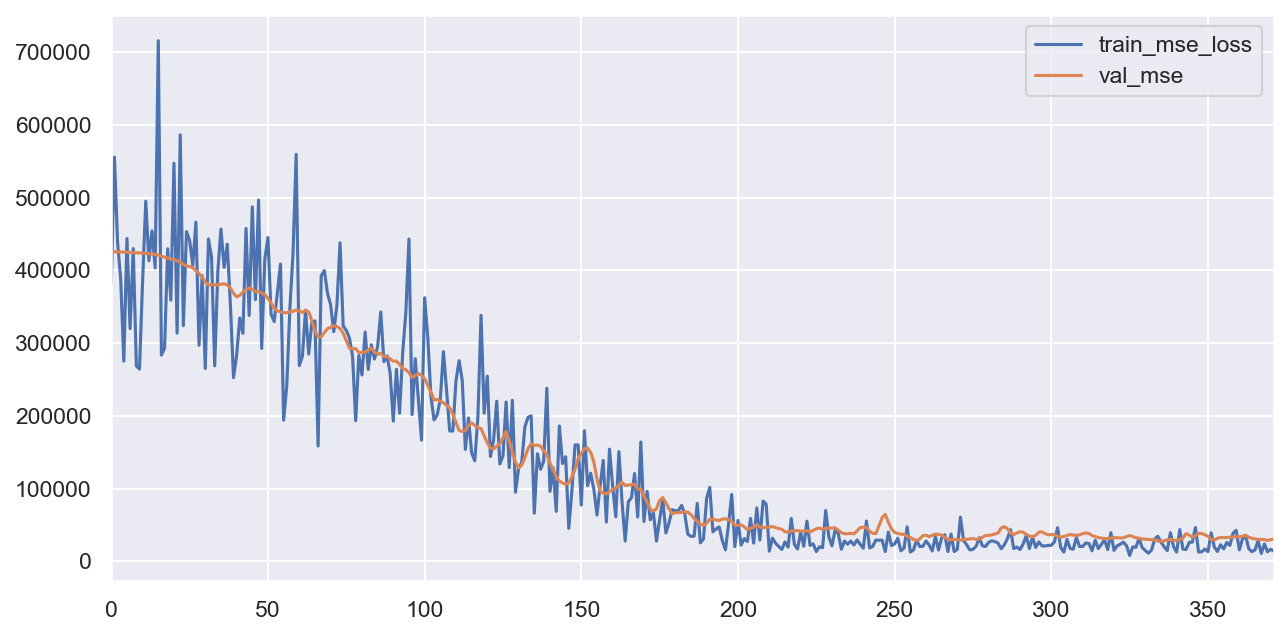

In [30]:
_, ax = plt.subplots(figsize=(10, 5), dpi=150)
trainer.training_info.plot(y=['train_mse_loss', 'val_mse'], ax=ax)

Missing directory and/or file name information!


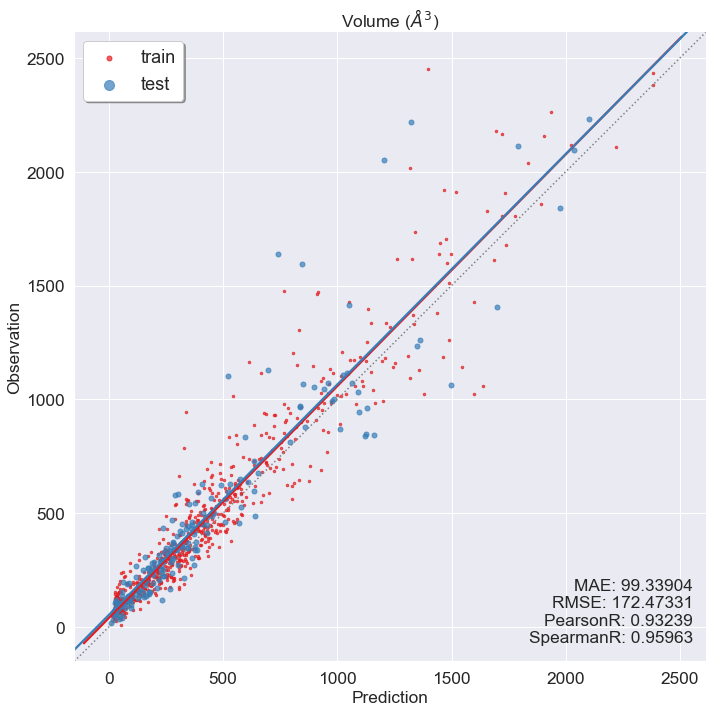

In [31]:
y_pred, y_true = trainer.predict(dataset=val_dataset, checkpoint='pearsonr_1')
y_fit_pred, y_fit_true = trainer.predict(dataset=train_dataset, checkpoint='pearsonr_1')
draw(y_true, y_pred, y_fit_true, y_fit_pred, prop_name='Volume ($\AA^3$)')

## Combine random model generating and training

In [32]:
generator = ParameterGenerator(
    in_features=290,
    out_features=1,
    h_neurons=dict(
        data=lambda n: sorted(np.random.uniform(0.2, 0.8, size=n), reverse=True), 
        repeat=(3, 4)
    )
)

In [33]:
for paras, model in generator(num=2, factory=SequentialLinear):
    print(model)
    model_name = make_name(model)
    persist = Persist(
        f'trained_models/{model_name}', 
        # -^- required -^-
        
        # -v- optional -v-
        increment=False, 
        sync_training_step=True,
        model_class=SequentialLinear,
        model_params=paras,
        author='Chang Liu',
        email='liu.chang.1865@gmail.com',
        dataset='materials project',
    )
    _ = trainer.extend(persist)
    trainer.reset(to=model)
    
    trainer.fit(training_dataset=train_dataset, validation_dataset=val_dataset, epochs=400)
    persist(splitter=sp, data_indices=prop.index.tolist())  # <-- calling of this method only after the model training

Training:   0%|          | 0/400 [00:00<?, ?it/s]

SequentialLinear(
  (layer_0): LinearLayer(
    (linear): Linear(in_features=290, out_features=195, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(195, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_1): LinearLayer(
    (linear): Linear(in_features=195, out_features=141, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(141, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_2): LinearLayer(
    (linear): Linear(in_features=141, out_features=131, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(131, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_3): LinearLayer(
    (linear): Linear(in_features=131, out_features=61, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(61, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation):

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 31 iterations, finish training at iteration 380
SequentialLinear(
  (layer_0): LinearLayer(
    (linear): Linear(in_features=290, out_features=214, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(214, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_1): LinearLayer(
    (linear): Linear(in_features=214, out_features=181, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(181, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_2): LinearLayer(
    (linear): Linear(in_features=181, out_features=141, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(141, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_3): LinearLayer(
    (linear): Linear(in_features=141, out_features=130, bias=True)
    (dropout)

Training:  10%|█         | 42/400 [00:14<02:18,  2.59it/s]

Early stopping is applied: no improvement for ['mae', 'pearsonr'] since the last 31 iterations, finish training at iteration 333
